In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', None)

In [11]:
#Leer data set
df = pd.read_csv('./bank-additional-full.csv', sep=';')

Distribución de clases (0=no, 1=si):
y
0    36548
1     4640
Name: count, dtype: int64 

Proporción cuenta adicional: 0.1127


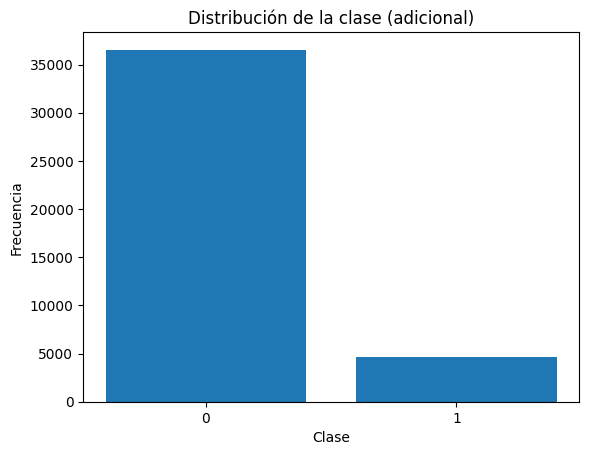

In [12]:
# Distribución de la clase
class_counts = df['y'].value_counts().sort_index()
print("Distribución de clases (0=no, 1=si):")
print(class_counts, "\n")
print("Proporción cuenta adicional:", round(df['y'].mean(), 4))

plt.figure()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Distribución de la clase (adicional)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

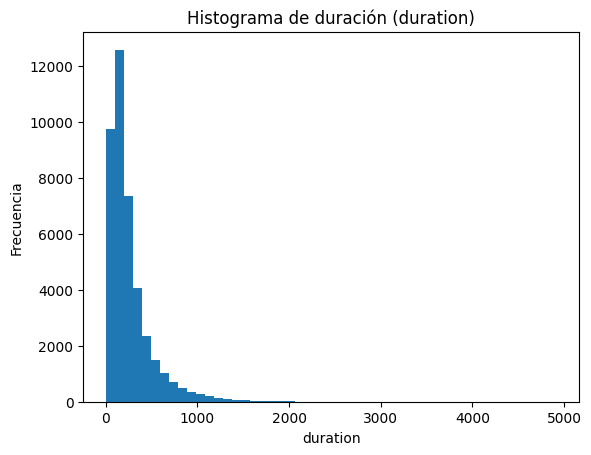

In [13]:
plt.figure()
plt.hist(df['duration'], bins=50)
plt.title("Histograma de duración (duration)")
plt.xlabel("duration")
plt.ylabel("Frecuencia")
plt.show()

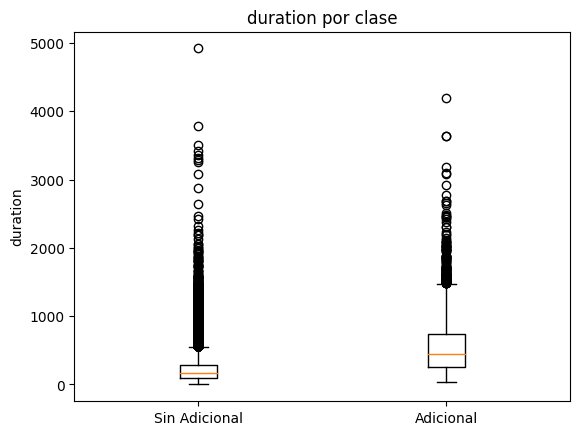

In [14]:
# Boxplot: duration por clase
plt.figure()
plt.boxplot([df.loc[df.y==0,'duration'], df.loc[df.y==1,'duration']], labels=['Sin Adicional','Adicional'])
plt.title("duration por clase")
plt.ylabel("duration")
plt.show()

                     age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   
y               0.030399  0.405274 -0.066357 -0.324914  0.230181   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968       

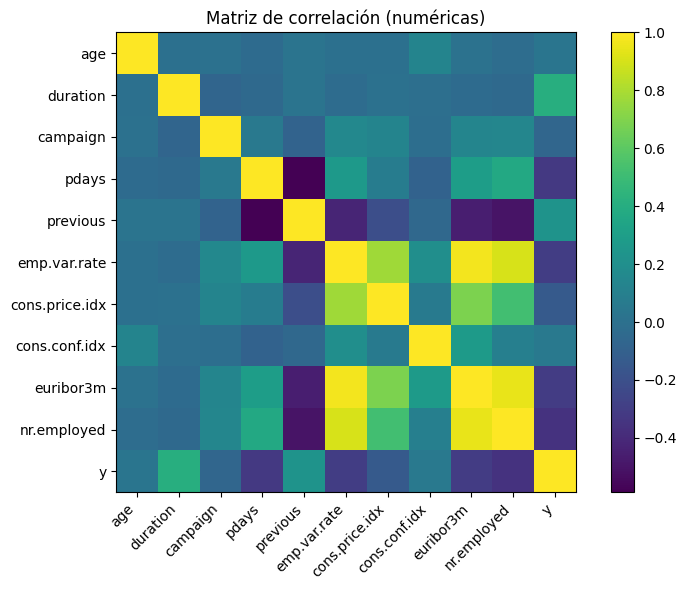

In [15]:
# Correlaciones (solo numéricas)
num_cols = df.select_dtypes(include=np.number)
corr = num_cols.corr()
print(corr)

plt.figure(figsize=(8, 6))  # Ajustar el tamaño del gráfico
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(num_cols.columns)), num_cols.columns, rotation=45, ha='right')
plt.yticks(range(len(num_cols.columns)), num_cols.columns)
plt.title("Matriz de correlación (numéricas)")
plt.colorbar()
plt.tight_layout()
plt.show()

In [16]:
#Feature Engineering y Split

X = df.drop('y', axis=1)
y = df['y']

numeric_features = ['age', 'duration']
categorical_features = ['campaign']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y
)

print(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())

(30891, 20) (10297, 20) 0.11265417111780131 0.11265417111780131


In [17]:
#Cross-Validation Helper
def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True)
    # Usamos ROC-AUC como métrica de CV (apropiada para clases desbalanceadas)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')

    # Entrenamiento final y predicciones en test
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    try:
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_proba)
    except Exception:
        y_proba = None
        roc = np.nan

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)

    # Resumen numérico
    print(f"\n=== {name} ===")
    print("Cross-validated ROC-AUC (mean ± std): ", round(cv_scores.mean(), 4), "±", round(cv_scores.std(), 4))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))

    # 1) Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sin Adicional','Adicional'])
    plt.figure()
    disp.plot(values_format='d')
    plt.title(f"Matriz de confusión — {name}")
    plt.show()

    # 2) Distribución de ROC-AUC en CV (boxplot)
    plt.figure()
    plt.boxplot(cv_scores, vert=True)
    plt.title(f"Cross-Validation ROC-AUC — {name}")
    plt.ylabel("ROC-AUC")
    plt.show()

    # 3) Puntajes por fold (línea simple)
    plt.figure()
    plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o')
    plt.title(f"ROC-AUC por fold — {name}")
    plt.xlabel("Fold")
    plt.ylabel("ROC-AUC")
    plt.xticks(range(1, len(cv_scores)+1))
    plt.show()

    # 4) Curva ROC en test (si hay probabilidades)
    if y_proba is not None:
        from sklearn.metrics import RocCurveDisplay
        plt.figure()
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"Curva ROC (test) — {name}")
        plt.show()

    return {
        'model': name,
        'cv_roc_auc_mean': cv_scores.mean(),
        'test_roc_auc': roc,
        'test_accuracy': acc,
        'test_f1': f1,
        'test_precision': prec,
        'test_recall': rec,
    }



=== DecisionTree (gini, default) ===
Cross-validated ROC-AUC (mean ± std):  0.6185 ± 0.0097

Classification Report:
              precision    recall  f1-score   support

           0     0.9130    0.9207    0.9168      9137
           1     0.3306    0.3086    0.3192      1160

    accuracy                         0.8517     10297
   macro avg     0.6218    0.6146    0.6180     10297
weighted avg     0.8473    0.8517    0.8495     10297



<Figure size 640x480 with 0 Axes>

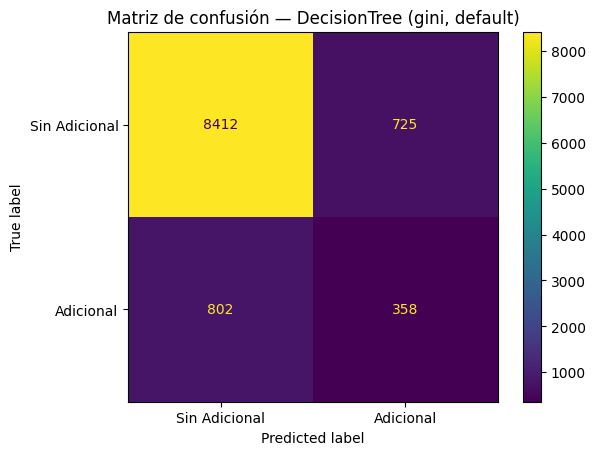

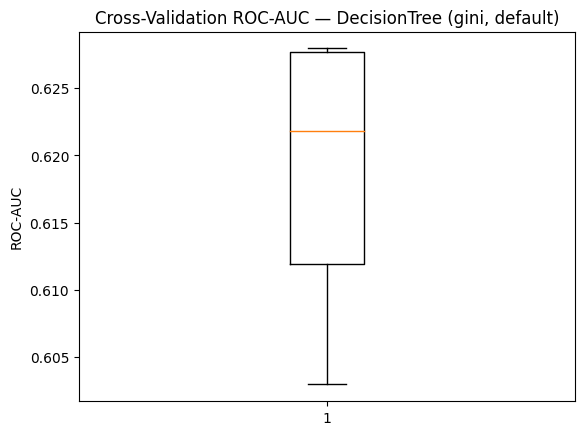

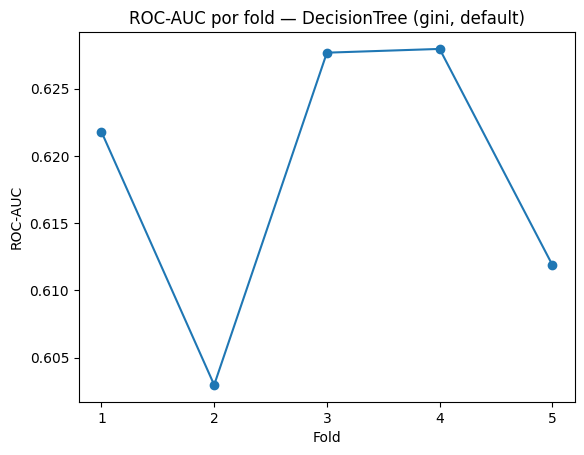

<Figure size 640x480 with 0 Axes>

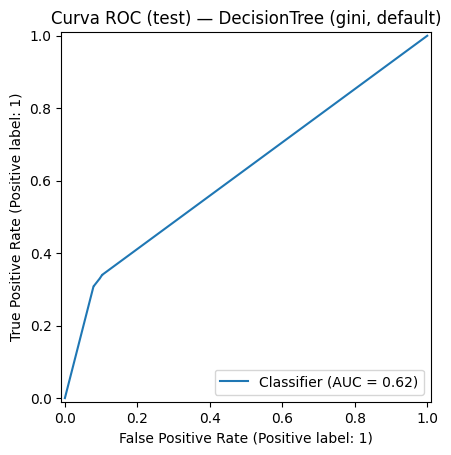

In [20]:
#Modelos

models_summary = []

dt_default = Pipeline(steps=[
    ('prep', preprocess),
    ('model', DecisionTreeClassifier())
])

res_dt_default = evaluate_model("DecisionTree (gini, default)", dt_default, X_train, y_train, X_test, y_test)
models_summary.append(res_dt_default)


=== DecisionTree (gini, max_depth=6) ===
Cross-validated ROC-AUC (mean ± std):  0.8329 ± 0.0047

Classification Report:
              precision    recall  f1-score   support

           0     0.9118    0.9808    0.9451      9137
           1     0.6261    0.2526    0.3600      1160

    accuracy                         0.8988     10297
   macro avg     0.7689    0.6167    0.6525     10297
weighted avg     0.8796    0.8988    0.8791     10297



<Figure size 640x480 with 0 Axes>

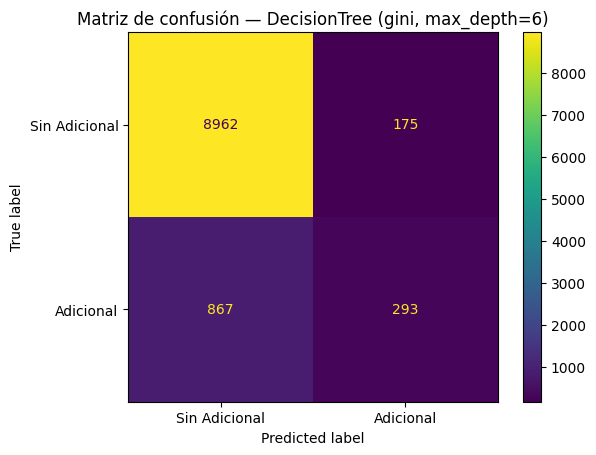

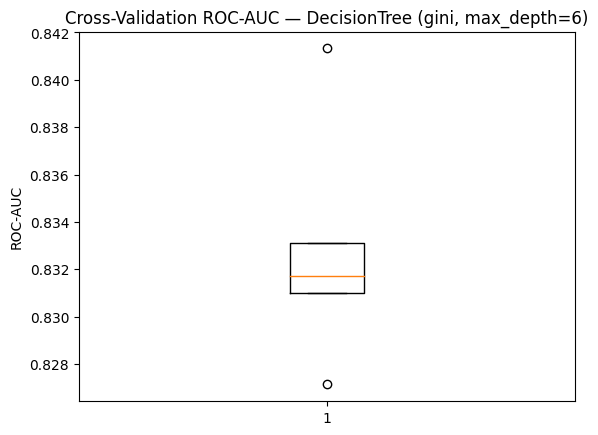

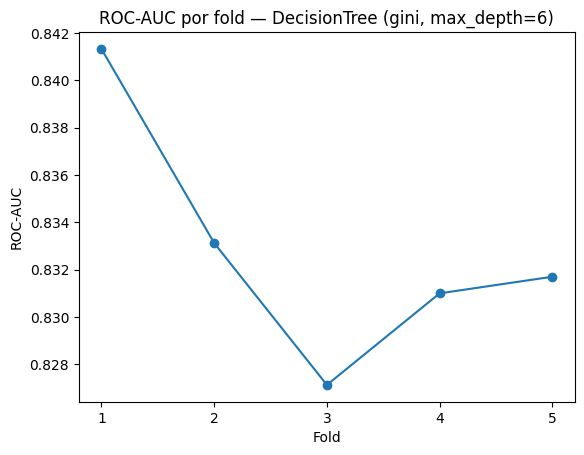

<Figure size 640x480 with 0 Axes>

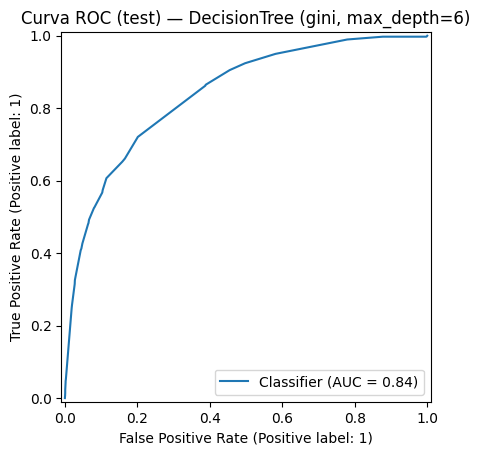

In [21]:
dt_depth = Pipeline(steps=[
    ('prep', preprocess),
    ('model', DecisionTreeClassifier(max_depth=6))
])

res_dt_depth = evaluate_model("DecisionTree (gini, max_depth=6)", dt_depth, X_train, y_train, X_test, y_test)
models_summary.append(res_dt_depth)


=== DecisionTree (entropy, max_depth=6) ===
Cross-validated ROC-AUC (mean ± std):  0.8328 ± 0.0083

Classification Report:
              precision    recall  f1-score   support

           0     0.9129    0.9802    0.9453      9137
           1     0.6276    0.2629    0.3706      1160

    accuracy                         0.8994     10297
   macro avg     0.7702    0.6216    0.6580     10297
weighted avg     0.8807    0.8994    0.8806     10297



<Figure size 640x480 with 0 Axes>

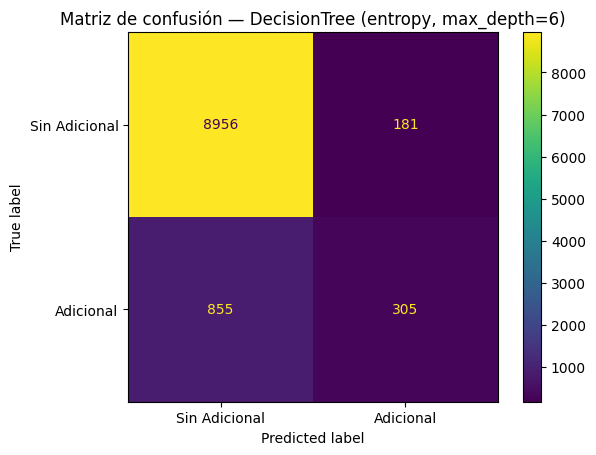

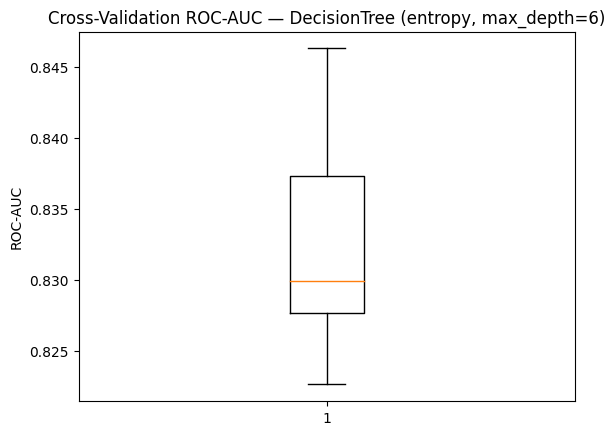

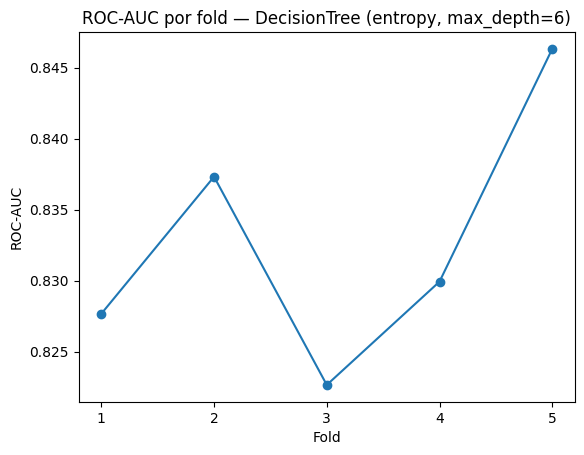

<Figure size 640x480 with 0 Axes>

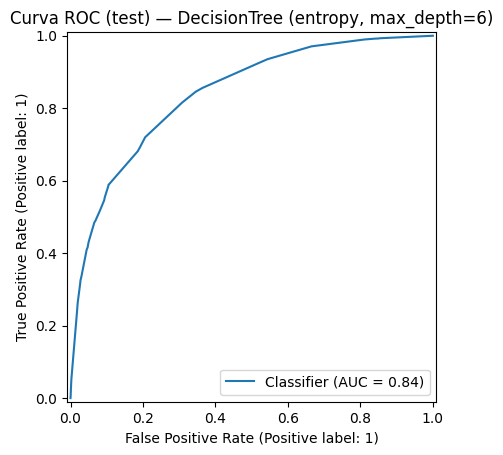

In [22]:
dt_entropy = Pipeline(steps=[
    ('prep', preprocess),
    ('model', DecisionTreeClassifier(criterion='entropy', max_depth=6))
])

res_dt_entropy = evaluate_model("DecisionTree (entropy, max_depth=6)", dt_entropy, X_train, y_train, X_test, y_test)
models_summary.append(res_dt_entropy)


=== KNN (weights='uniform') ===
Cross-validated ROC-AUC (mean ± std):  0.7452 ± 0.0101

Classification Report:
              precision    recall  f1-score   support

           0     0.9120    0.9636    0.9370      9137
           1     0.4821    0.2672    0.3439      1160

    accuracy                         0.8851     10297
   macro avg     0.6970    0.6154    0.6405     10297
weighted avg     0.8635    0.8851    0.8702     10297



<Figure size 640x480 with 0 Axes>

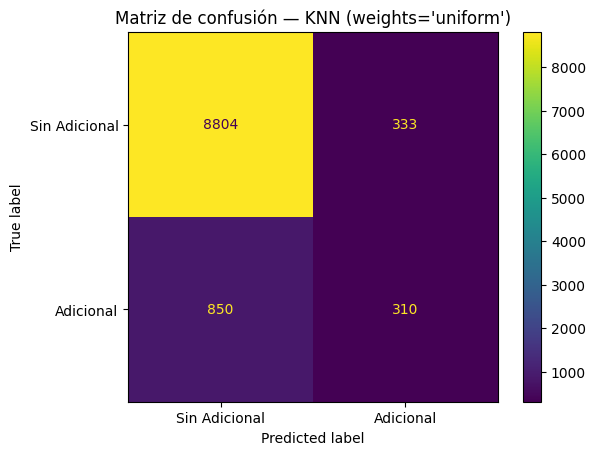

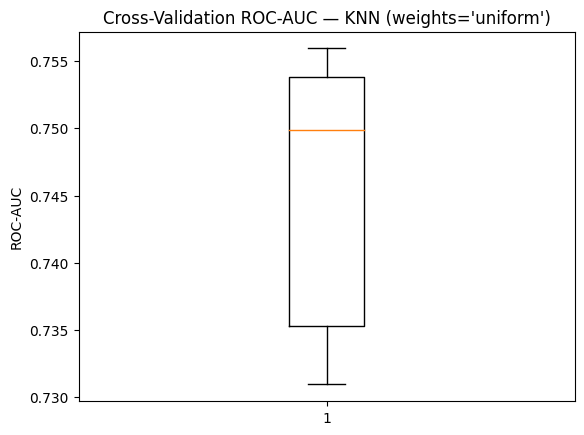

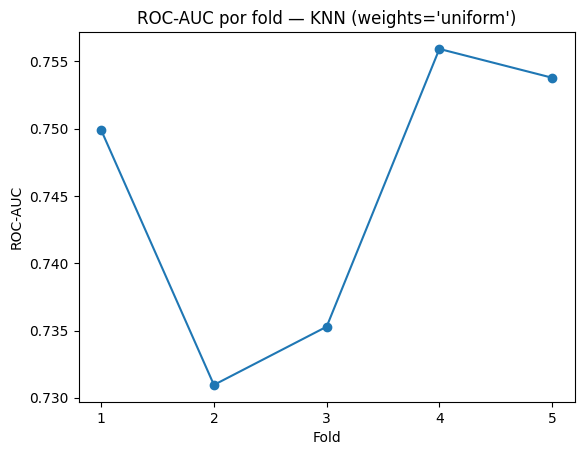

<Figure size 640x480 with 0 Axes>

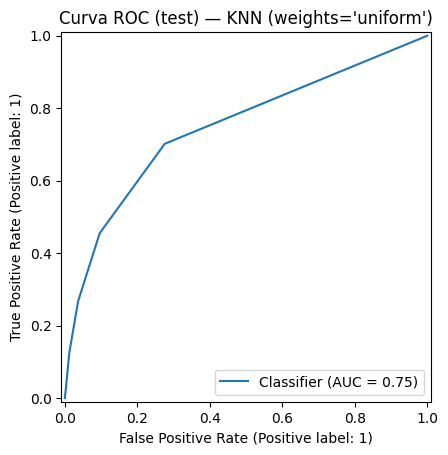

In [21]:
knn_uniform = Pipeline(steps=[
    ('prep', preprocess),
    ('model', KNeighborsClassifier(n_neighbors=5, weights='uniform'))
])

res_knn_uniform = evaluate_model("KNN (weights='uniform')", knn_uniform, X_train, y_train, X_test, y_test)
models_summary.append(res_knn_uniform)


=== KNN (weights='distance') ===
Cross-validated ROC-AUC (mean ± std):  0.7296 ± 0.0085

Classification Report:
              precision    recall  f1-score   support

           0     0.9144    0.9401    0.9271      9137
           1     0.3942    0.3069    0.3451      1160

    accuracy                         0.8688     10297
   macro avg     0.6543    0.6235    0.6361     10297
weighted avg     0.8558    0.8688    0.8615     10297



<Figure size 640x480 with 0 Axes>

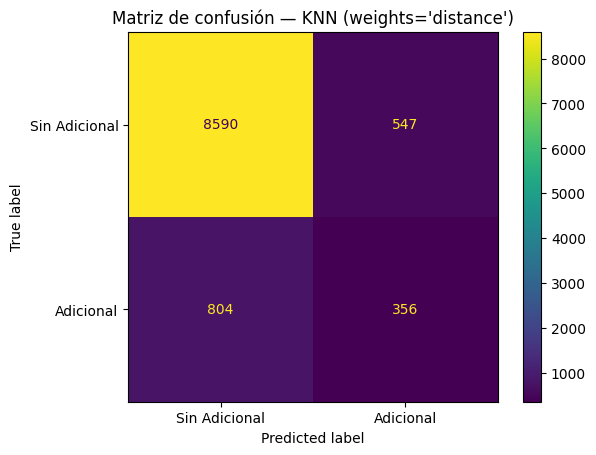

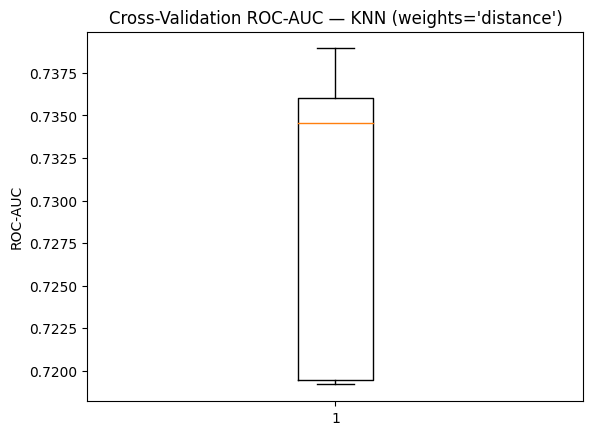

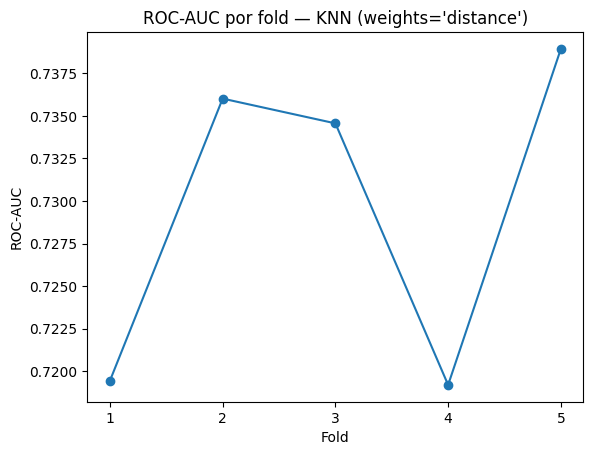

<Figure size 640x480 with 0 Axes>

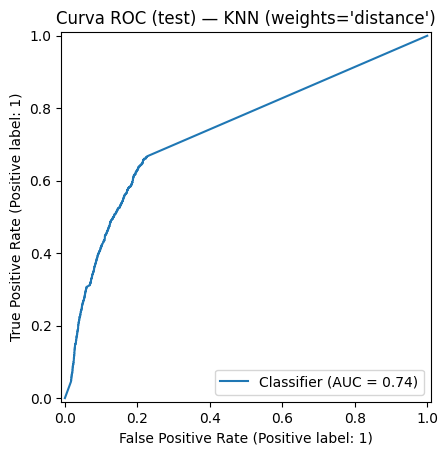

In [24]:
knn_distance = Pipeline(steps=[
    ('prep', preprocess),
    ('model', KNeighborsClassifier(n_neighbors=5, weights='distance'))
])

res_knn_distance = evaluate_model("KNN (weights='distance')", knn_distance, X_train, y_train, X_test, y_test)
models_summary.append(res_knn_distance)

In [23]:
#Leaderboard de Modelos
leaderboard = pd.DataFrame(models_summary).sort_values(by=['test_f1','test_roc_auc','test_accuracy'], ascending=False)
leaderboard.reset_index(drop=True, inplace=True)
leaderboard

,model,cv_roc_auc_mean,test_roc_auc,test_accuracy,test_f1,test_precision,test_recall
0,KNN (weights='distance'),0.730746,0.737750,0.868797,0.345128,0.394241,0.306897
1,KNN (weights='uniform'),0.745170,0.747301,0.885112,0.343871,0.482115,0.267241
2,"DecisionTree (gini, default)",0.618454,0.621038,0.851704,0.319215,0.330563,0.308621
